In [1]:
#!pip install --upgrade tensorflow_hub

In [2]:
# !pip install tensorflow-datasets
# !pip install bert-for-tf2
# !pip install tensorflow_hub

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import string
from string import digits
import re
import time
import numpy as np
import pandas as pd
import collections
import unicodedata

import os

from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights

import  nltk.translate.bleu_score as bleu

In [3]:
tf.config.list_physical_devices('GPU')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [4]:
# gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
# tf.io.gfile.listdir(gs_folder_bert)

In [5]:
os.getcwdb()

C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The Windows bytes API has been deprecated, use Unicode filenames instead
  """Entry point for launching an IPython kernel.


b'C:\\Users\\user\\Project From Alex NLP'

In [6]:
# # https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# if not os.path.exists('/BERT/uncased_L-12_H-768_A-12'):
#   !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
#   !unzip uncased_L-12_H-768_A-12

In [7]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

In [8]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#   sentence = '<start> ' + sentence + ' <end>'
  return sentence


def load_conversations(num1,num2):
  # dictionary of line id to text
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines[num1:num2]:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
#       if len(inputs) >= MAX_SAMPLES:
#         return inputs, outputs
  return inputs, outputs

In [9]:
questions, answers = load_conversations(0,20000)
len(questions),len(answers)

(53430, 53430)

In [10]:
questions_val, answers_val = load_conversations(80001,80500)
len(questions_val),len(answers_val)

(1634, 1634)

In [11]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [12]:
# hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [13]:
# with open('/content/drive/My Drive/machine translation/pol-eng.zip (Unzipped Files)/pol.txt','r') as f:
#   data = f.read()

In [14]:
# uncleaned_data_list = data.strip().split('\n')
# len(uncleaned_data_list)

In [15]:
# uncleaned_data_list = uncleaned_data_list[:38695]

In [16]:
# english_word = []
# polish_word = []
# cleaned_data_list = []
# for word in uncleaned_data_list:
#   english_word.append(word.split('\t')[:-1][0])
#   polish_word.append(word.split('\t')[:-1][1])

In [17]:
# data = pd.DataFrame(columns=['English','Polish'])
# data['English'] = english_word
# data['Polish'] = polish_word

In [18]:
# data.to_csv('data.csv', index=False)

In [19]:
# data = pd.read_csv('data.csv')
# data.head()

In [20]:
# we will take 80% data in train and remaining in test
# train = int(len(data)*0.8)
# test = len(data) - train
# train_examples, val_examples = data.iloc[0:train,:], data.iloc[train:len(data),:]

In [21]:
# english_text = train_examples['English'].values
# polish_text = train_examples['Polish'].values

In [22]:
# english_val_text = val_examples['English'].values
# polish_val_text = val_examples['Polish'].values

In [23]:
train_examples = tf.data.Dataset.from_tensor_slices((questions, answers))
val_examples = tf.data.Dataset.from_tensor_slices((questions_val, answers_val))

In [24]:
# type(train_examples)

In [25]:
# print(train_examples)

In [26]:
# for en, pl in train_examples.take(1):
#   print(tf.compat.as_text(en.numpy()))
#   print(tf.compat.as_text(pl.numpy()))

In [27]:
def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if isinstance(text, str):
        return text
    elif isinstance(text, bytes):
        return text.decode("utf-8", "ignore")
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.io.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

def convert_by_vocab(vocab, items):
    """Converts a sequence of [tokens|ids] using the vocab."""
    output = []
    for item in items:
        output.append(vocab[item])
    return output

class FullTokenizer(object):
    """Runs end-to-end tokenziation."""

    def __init__(self, vocab_file, do_lower_case=True):
        self.vocab = load_vocab(vocab_file)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

    def tokenize(self, text):
        split_tokens = []
        for token in self.basic_tokenizer.tokenize(text):
            for sub_token in self.wordpiece_tokenizer.tokenize(token):
                split_tokens.append(sub_token)

        return split_tokens
    
    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

    def convert_ids_to_tokens(self, ids):
        return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True):
        """Constructs a BasicTokenizer.
    
        Args:
          do_lower_case: Whether to lower case the input.
        """
        self.do_lower_case = do_lower_case

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = convert_to_unicode(text)
        text = self._clean_text(text)

        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        text = self._tokenize_chinese_chars(text)

        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenziation."""

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.
    
        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.
    
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
    
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer.
    
        Returns:
          A list of wordpiece tokens.
        """

        text = convert_to_unicode(text)

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens

def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

Create a custom subwords tokenizer from the training dataset for the decoder.

In [28]:
tokenizer_ans = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    answers, target_vocab_size=2**13)
tokenizer_ans.save_to_file('vocab_ans')

sample_string = 'Transformer is awesome.'
tokenized_string = tokenizer_ans.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_ans.decode([ts])))

7853 ----> T
1420 ----> ran
7884 ----> s
7495 ----> former
7801 ---->  
22 ----> is 
873 ----> aw
7524 ----> esome
7815 ----> .


In [29]:
# vocab_file = '/content/drive/My Drive/machine translation/vocab_pl'
# if os.path.isfile(vocab_file + '.subwords'):
#   tokenizer_pl = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_file)
# else: 
#   tokenizer_pl = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#       (polish_text), target_vocab_size=2 ** 13)
#   tokenizer_pl.save_to_file('vocab_pl')

# sample_string = 'Transformer jest niesamowity.'
# tokenized_string = tokenizer_pl.encode(sample_string)
# for ts in tokenized_string:
#   print ('{} ----> {}'.format(ts, tokenizer_pl.decode([ts])))

The encoder uses BERT tokenizer.

In [30]:
tokenizer_ques = FullTokenizer(
    vocab_file= 'uncased_L-12_H-768_A-12/vocab.txt',
    do_lower_case=True)

test_tokens = tokenizer_ques.tokenize(questions[-1])
test_ids = tokenizer_ques.convert_tokens_to_ids(['[CLS]'] + test_tokens + ['[SEP]'])
print(test_ids)
print(tokenizer_ques.convert_ids_to_tokens(test_ids))

[101, 1012, 1012, 1012, 1045, 2180, 1056, 2175, 2046, 2008, 2651, 1012, 2295, 1010, 2065, 2057, 2323, 3613, 2122, 6521, 1010, 2004, 1045, 5121, 3246, 2057, 2097, 1010, 2045, 2024, 2070, 5919, 1997, 2008, 1045, 2052, 2066, 2000, 2298, 2012, 1012, 2643, 4282, 1010, 1045, 2310, 7791, 2000, 2438, 2111, 3228, 2033, 1996, 28900, 1012, 1012, 1012, 2012, 2151, 3446, 1010, 1045, 2074, 2359, 2000, 13399, 1996, 4937, 20766, 6774, 3466, 2115, 7615, 2018, 2006, 2033, 1012, 1045, 2074, 3246, 2008, 2009, 2987, 1056, 2272, 25223, 2989, 2067, 2588, 2017, 2066, 2070, 21794, 2104, 18790, 1012, 102]
['[CLS]', '.', '.', '.', 'i', 'won', 't', 'go', 'into', 'that', 'today', '.', 'though', ',', 'if', 'we', 'should', 'continue', 'these', 'sessions', ',', 'as', 'i', 'certainly', 'hope', 'we', 'will', ',', 'there', 'are', 'some', 'aspects', 'of', 'that', 'i', 'would', 'like', 'to', 'look', 'at', '.', 'god', 'knows', ',', 'i', 've', 'listened', 'to', 'enough', 'people', 'giving', 'me', 'the', 'juicy', '.', '.', '

In [31]:
MAX_SEQ_LENGTH = 40


def encode(en, pl, seq_length=MAX_SEQ_LENGTH):
  tokens_en = tokenizer_ques.tokenize(tf.compat.as_text(en.numpy()))
  lang1 = tokenizer_ques.convert_tokens_to_ids(['[CLS]'] + tokens_en + ['[SEP]'])
  if len(lang1)<seq_length:
    lang1 = lang1 + list(np.zeros(seq_length - len(lang1), 'int32'))

  lang2 = [tokenizer_ans.vocab_size] + tokenizer_ans.encode(tf.compat.as_text(pl.numpy())) + [tokenizer_ans.vocab_size + 1]
  if len(lang2)<seq_length:
    lang2 = lang2 + list(np.zeros(seq_length - len(lang2), 'int32'))

  return lang1, lang2

In [32]:
def tf_encode(en, pl):
  result_en, result_pl = tf.py_function(encode, [en, pl], [tf.int32, tf.int32])
  result_en.set_shape([None])
  result_pl.set_shape([None])

  return result_en, result_pl

In [33]:
def filter_max_length(x, y, max_length=MAX_SEQ_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

encode text into integers

In [34]:
print(len(questions))

53430


In [35]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = train_examples.map(tf_encode)
# train_dataset = tf.io.decode_raw(train_dataset, tf.int32)
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]), drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(
    lambda en, pl: tf.py_function(encode, [en, pl], [tf.int32, tf.int32]))
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [36]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

In [37]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)

    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [38]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [39]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

Scaled dot product attention

In [40]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
      
    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

Multi-Head-Attention

In [41]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [42]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 768))  # (batch_size, encoder_sequence, d_model)
q = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=q, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [43]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

Encoder Layer and Encoder

Use bert as encoder. The output shape is (batch_size, input_seq_len, d_model).

In [44]:
def build_encoder(config_file):
    with tf.io.gfile.GFile(config_file, "r") as reader:
        stock_params = StockBertConfig.from_json_string(reader.read())
        bert_params = stock_params.to_bert_model_layer_params()

    return BertModelLayer.from_params(bert_params, name="bert")

Decoder Layer and Decoder


Each decoder layer consists of sublayers:

1.) Masked multi-head attention (with look ahead mask and padding mask)

2.) Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublaye

3.) Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [45]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [46]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_encoder_output = tf.random.uniform((64, 128, 768))

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

The Decoder consists of: 1. Output Embedding 2. Positional Encoding 3. N decoder layers

In [47]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [48]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 128]))

Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [49]:
class Config(object):
  def __init__(self, num_layers, d_model, dff, num_heads):
    self.num_layers = num_layers
    self.d_model = d_model
    self.dff = dff
    self.num_heads= num_heads

In [50]:
from bert.loader import map_to_stock_variable_name
# /content/drive/My Drive/machine translation/transformer/bert
class Transformer(tf.keras.Model):
  def __init__(self, config,
               target_vocab_size, 
               bert_config_file,
               bert_training=False, 
               rate=0.1,
               name='transformer'):
      super(Transformer, self).__init__(name=name)

      self.encoder = build_encoder(config_file=bert_config_file)
      self.encoder.trainable = bert_training

      self.decoder = Decoder(config.num_layers, config.d_model, 
                             config.num_heads, config.dff, target_vocab_size, rate)

      self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def load_stock_weights(self, bert: BertModelLayer, ckpt_file):
      assert isinstance(bert, BertModelLayer), "Expecting a BertModelLayer instance as first argument"
      assert tf.compat.v1.train.checkpoint_exists(ckpt_file), "Checkpoint does not exist: {}".format(ckpt_file)
      ckpt_reader = tf.train.load_checkpoint(ckpt_file)

      bert_prefix = 'transformer/bert'

      weights = []
      for weight in bert.weights:
          stock_name = map_to_stock_variable_name(weight.name, bert_prefix)
          if ckpt_reader.has_tensor(stock_name):
              value = ckpt_reader.get_tensor(stock_name)
              weights.append(value)
          else:
              raise ValueError("No value for:[{}], i.e.:[{}] in:[{}]".format(weight.name, stock_name, ckpt_file))
      bert.set_weights(weights)
      print("Done loading {} BERT weights from: {} into {} (prefix:{})".format(
          len(weights), ckpt_file, bert, bert_prefix))

  def restore_encoder(self, bert_ckpt_file):
      # loading the original pre-trained weights into the BERT layer:
      self.load_stock_weights(self.encoder, bert_ckpt_file)

  def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp, training=self.encoder.trainable)  # (batch_size, inp_seq_len, d_model)

      # dec_output.shape == (batch_size, tar_seq_len, d_model)
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

      return final_output, attention_weights

Set hyperparameters

In [51]:
target_vocab_size = tokenizer_ans.vocab_size + 2
dropout_rate = 0.1
config = Config(num_layers=6, d_model=512, dff=1024, num_heads=8)

In [52]:
# target_vocab_size = tokenizer_ans.vocab_size + 2
# dropout_rate = 0.1
# config = Config(num_layers=4, d_model=128, dff=512, num_heads=8)

In [53]:
# gs_folder_bert
# uncased_L-12_H-768_A-12
MODEL_DIR = "uncased_L-12_H-768_A-12"
bert_config_file = os.path.join(MODEL_DIR, "bert_config.json")
bert_ckpt_file = os.path.join(MODEL_DIR, 'bert_model.ckpt')

# with tpu_strategy.scope():
transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
tar_inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
fn_out, _ = transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
print(tar_inp.shape) # (batch_size, tar_seq_len) 
print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size) 

# init bert pre-trained weights
transformer.restore_encoder(bert_ckpt_file)

(64, 40)
(64, 40, 8027)
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Done loading 196 BERT weights from: uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000011990E62DC8> (prefix:transformer/bert)


In [54]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        multiple                  108890112 
_________________________________________________________________
decoder_1 (Decoder)          multiple                  24609280  
_________________________________________________________________
dense_94 (Dense)             multiple                  4117851   
Total params: 137,617,243
Trainable params: 28,727,131
Non-trainable params: 108,890,112
_________________________________________________________________


Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [56]:
learning_rate = CustomSchedule(config.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

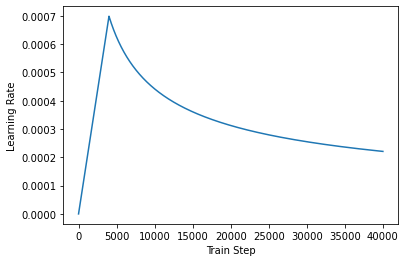

In [57]:
temp_learning_rate_schedule = CustomSchedule(config.d_model)
import matplotlib.pyplot as plt

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [58]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [59]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [60]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

Training and checkpointing

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [61]:
checkpoint_path = "/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [62]:
def create_masks(inp, tar):
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

In [63]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [64]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> chinese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 500 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0425 Accuracy 0.0000
Epoch 1 Batch 500 Loss 2.1523 Accuracy 0.0384
Saving checkpoint for epoch 1 at /checkpoints/train\ckpt-1
Epoch 1 Loss 1.9816 Accuracy 0.0489
Time taken for 1 epoch: 179.40690636634827 secs

Epoch 2 Batch 0 Loss 1.2983 Accuracy 0.0741
Epoch 2 Batch 500 Loss 1.5130 Accuracy 0.0775
Saving checkpoint for epoch 2 at /checkpoints/train\ckpt-2
Epoch 2 Loss 1.4945 Accuracy 0.0786
Time taken for 1 epoch: 147.422048330307 secs

Epoch 3 Batch 0 Loss 1.4501 Accuracy 0.0909
Epoch 3 Batch 500 Loss 1.4165 Accuracy 0.0834
Saving checkpoint for epoch 3 at /checkpoints/train\ckpt-3
Epoch 3 Loss 1.4134 Accuracy 0.0837
Time taken for 1 epoch: 146.74531626701355 secs

Epoch 4 Batch 0 Loss 1.5853 Accuracy 0.0913
Epoch 4 Batch 500 Loss 1.3636 Accuracy 0.0860
Saving checkpoint for epoch 4 at /checkpoints/train\ckpt-4
Epoch 4 Loss 1.3748 Accuracy 0.0861
Time taken for 1 epoch: 147.1535291671753 secs

Epoch 5 Batch 0 Loss 1.5032 Accuracy 0.0869
Epoch 5 Batch 500 Loss 

Evaluate


The following steps are used for evaluation:

Encode the input sentence using the english tokenizer (tokenizer_en). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.

The decoder input is the start token == tokenizer_pl.vocab_size.

Calculate the padding masks and the look ahead masks.

The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).

Select the last word and calculate the argmax of that.

Concatentate the predicted word to the decoder input as pass it to the decoder.

In this approach, the decoder predicts the next word based on the previous words it predicted.

In [65]:
def encode_en(en):
    tokens_en = tokenizer_ques.tokenize(en)
    lang1 = tokenizer_ques.convert_tokens_to_ids(['[CLS]'] + tokens_en + ['[SEP]'])
    return lang1

In [66]:
def evaluate(transformer, inp_sentence):
    # normalize input sentence
    inp_sentence = encode_en(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_ans.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_SEQ_LENGTH):
        combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_ans.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [67]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  test_tokens = tokenizer_ques.tokenize(sentence)
  sentence = tokenizer_ques.convert_tokens_to_ids(test_tokens)

#   sentence = tokenizer_ques.tokenize(sentence) #.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_ques.convert_ids_to_tokens([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_ans.decode([i]) for i in result 
                        if i < tokenizer_ans.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [68]:
def chatbot(transformer, sentence, plot=''):
    result, attention_weights = evaluate(transformer, sentence)

    predicted_sentence = tokenizer_ans.decode([i for i in result
                                              if i < tokenizer_ans.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted Response: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
    
    return predicted_sentence

Input: who are you?
Predicted Response: i am .


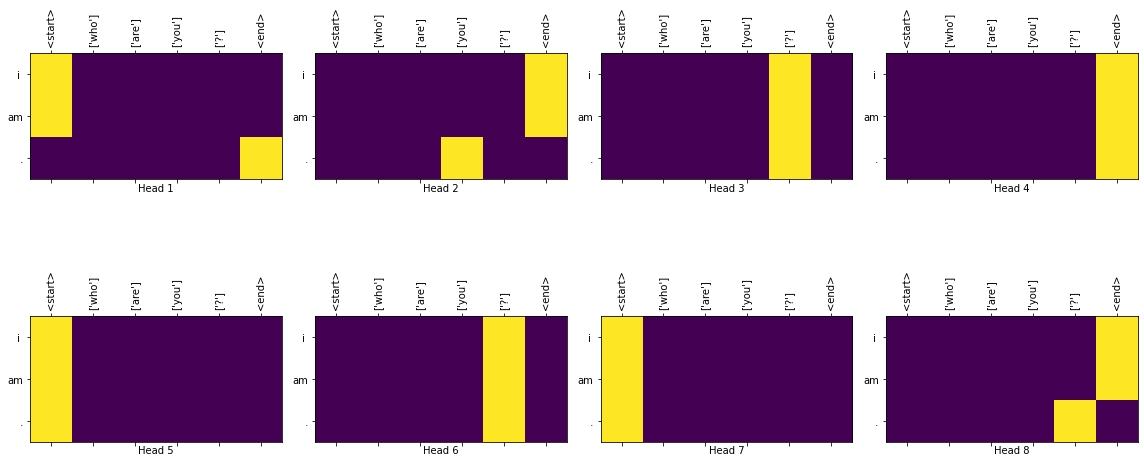

'i am .'

In [69]:
chatbot(transformer, 'who are you?',plot='decoder_layer4_block2')

In [70]:
chatbot(transformer, 'tom intervened.')

Input: tom intervened.
Predicted Response: i don t want to know .


'i don t want to know .'

In [71]:
chatbot(transformer, 'tom looks happy.')

Input: tom looks happy.
Predicted Response: i ve been so much since good for a damn time for a while .


'i ve been so much since good for a damn time for a while .'

In [72]:
chatbot(transformer, 'tom hid under the table.')

Input: tom hid under the table.
Predicted Response: i think i trust you .


'i think i trust you .'

In [73]:
chatbot(transformer, 'please pass my laptop.')

Input: please pass my laptop.
Predicted Response: and i will rather take a sound with you .


'and i will rather take a sound with you .'

In [74]:
chatbot(transformer, 'i love you.')

Input: i love you.
Predicted Response: i love you . you re crazy . you re crazy . you don t even even even even even even even even even even even even even even even even even even even even even even even even even 


'i love you . you re crazy . you re crazy . you don t even even even even even even even even even even even even even even even even even even even even even even even even even '

In [75]:
chatbot(transformer, 'beautifull')

Input: beautifull
Predicted Response: it s not the most one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of 


'it s not the most one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of awful one of '

Save weights

In [76]:
transformer.save_weights('/weights/chatbot_bert_ckpt')

In [77]:
new_transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
fn_out, _ = new_transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
new_transformer.load_weights('/weights/chatbot_bert_ckpt')

In [78]:
chatbot(new_transformer, 'go.')

Input: go.
Predicted Response: okay . thanks .


'okay . thanks .'

In [79]:
chatbot(new_transformer, 'take a walk every day.')

Input: take a walk every day.
Predicted Response: it s a top of time . it s nothing to stay for it .


'it s a top of time . it s nothing to stay for it .'

In [80]:
chatbot(new_transformer, 'i still dont like you.')

Input: i still dont like you.
Predicted Response: i don t like a man to be a man to be there .


'i don t like a man to be a man to be there .'

In [81]:
chatbot(new_transformer, ' i have just washed all the dishes.')

Input:  i have just washed all the dishes.
Predicted Response: i know how to do with them to do with them to do with them to do with them to do with them to do with them to do with them to do with them to do with them to 


'i know how to do with them to do with them to do with them to do with them to do with them to do with them to do with them to do with them to do with them to '

In [82]:
# feed the model with its previous output
sentence = 'Who are you?'
for _ in range(5):
  sentence = chatbot(new_transformer, sentence)
  print('')

Input: Who are you?
Predicted Response: i am .

Input: i am .
Predicted Response: you re sure . you ve been crazy .

Input: you re sure . you ve been crazy .
Predicted Response: i don t have a lot of that .

Input: i don t have a lot of that .
Predicted Response: i know how you do .

Input: i know how you do .
Predicted Response: i do . i do . i do . i do . i do . i do . i do . i do . i do . i do . i do . i do . i do . i 



In [83]:
bleuplus = 0

for ques_, ans_ in zip(questions_val,answers_val):
    predicted = chatbot(new_transformer, ques_)
    print('Real Response: {}'.format(ans_))
    bleu_ = bleu.sentence_bleu([ans_.split()], predicted.split())
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_

Input: what is it , son ?
Predicted Response: nothing . i m a little girl . i m an orid have to have to have to have to have to have to have to have to have to have to have to have to have to have 
Real Response: two more hogs got the fever .
BLEU Score:  7.290245807398516e-232
--------------------------------------------------------------------------------


C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\user\Anaconda3\envs\tf-gpu-env\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

Input: who s he ?
Predicted Response: red live .
Real Response: best we move that pig .
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
Input: hullo , paw .
Predicted Response: don t understand . it s a lot of mission .
Real Response: i guess you lost some hogs to the fever .
BLEU Score:  1.0003688322288243e-231
--------------------------------------------------------------------------------
Input: i guess you lost some hogs to the fever .
Predicted Response: i m not sure . i m not sure .
Real Response: three .
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: three .
Predicted Response: father , father . i ll take you in the sixtly .
Real Response: three ? that ain t bad considerin .
BLEU Score:  9.788429383461836e-232
--------------------------------------------------------------------------------
Input: that fella come by . . . tom .
Predict

Input: you was right to change your mind , kid .
Predicted Response: you don t want to go to be a family in that stuff . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re 
Real Response: yeah ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: yeah ?
Predicted Response: i don t believe you . but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but 
Real Response: i m a damn good shot . see that hawk up there ? i could kill that hawk with one shot .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
Input: far enough .
Predicted Response: well , i can t take him at you .
Real Response: we ain t goin to nebraska on no turtle hunt . a hundred yards ?
BLEU Score:  7.389560029878221e-232
---------------------------------------------------------------

Input: we done that stuff .
Predicted Response: i can t take you right from the money and we were the money and we do that .
Real Response: well i guess bill munny wasn t no fearless killer an bank robber like he said .
BLEU Score:  1.1484186507842885e-231
--------------------------------------------------------------------------------
Input: he s gonna die , ain t he ?
Predicted Response: he s not dead .
Real Response: maybe .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: maybe .
Predicted Response: i don t have to do what to do to do to do to do to do to do to do to do to do to do to do to do to do to do to do to do to 
Real Response: well , suppose he does ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: well , suppose he does ?
Predicted Response: yes , sir . he ll be a daughter .
Real Response: we ll bury him .
BLEU Score:  1.2183324802375697e-231


Input: lt lt we were there to buy a man and take him back to hungary . gt gt
Predicted Response: so you saw me , so you were going to see me .
Real Response: he says they were buying it doesn t make sense . i m sorry , i m a little rusty . they were there to buy something .
BLEU Score:  4.2798491878490225e-232
--------------------------------------------------------------------------------
Input: not dope . something else . some what ? . . he doesn t knob what they were buying . but not dope . . . people .
Predicted Response: what does the suspect with you ?
Real Response: lt lt i ll tell you everything . i even say it slow enough for you to understand it . just tell this man i want protection . real protection . gt gt
BLEU Score:  2.729857791638066e-233
--------------------------------------------------------------------------------
Input: lt lt no , no , no . i need a guarantee from the ridiculous man . i am going to be killed . i have seen the devil and looked him in the eye . gt gt

Input: i don t know what you came here for , but we won t have any part of it .
Predicted Response: you re crazy . you re crazy .
Real Response: edie , please .
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: i know who he is .
Predicted Response: who ?
Real Response: i hope i didn t disturb you .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i hope i didn t disturb you .
Predicted Response: not at all .
Real Response: i hope so , too , mr . kint . can i get you something to drink ?
BLEU Score:  3.8901167815143597e-233
--------------------------------------------------------------------------------
Input: i hope so , too , mr . kint . can i get you something to drink ?
Predicted Response: no , sir . i really had to get a drink .
Real Response: a glass of water would be nice .
BLEU Score:  1.1640469867513693e-231
------------------------------------------

Input: keaton , we gotta go . they re gonna find him .
Predicted Response: i can t trust you . i just like a part of the ship .
Real Response: dig .
BLEU Score:  9.257324954728539e-232
--------------------------------------------------------------------------------
Input: it s a logistical nightmare . close quarters , no advance layout , ten men , maybe twenty .
Predicted Response: we re not sure .
Real Response: can we stealth these guys ?
BLEU Score:  9.97486269044271e-232
--------------------------------------------------------------------------------
Input: can we stealth these guys ?
Predicted Response: we ve got a look in the car .
Real Response: doubtful . with all that coke , they ll be ready which brings me to sunny spot number two . even if one of us gets through and jacks the boat , we get nothing .
BLEU Score:  6.891988818303256e-233
--------------------------------------------------------------------------------
Input: i know you . you don t think i know you re on the take

Input: i be alright .
Predicted Response: i am sorry to this . i m ready . i m ready . i m ready . i m ready . i m ready . i m ready . i m ready . i m ready . i m 
Real Response: well , i m sorry .
BLEU Score:  3.3566500347661918e-155
--------------------------------------------------------------------------------
Input: well , i m sorry .
Predicted Response: well , i can t take a goddamn one . i can t even even even even even even even even even even even even even even even even even even even even even even even even even even even 
Real Response: forget it . i probably shit blood tonight .
BLEU Score:  2.8225949814960253e-155
--------------------------------------------------------------------------------
Input: how are they going to do it ?
Predicted Response: i don t know . i guess it s a simple .
Real Response: mcmanus wants to go in shooting . i said no way .
BLEU Score:  5.791739854583281e-155
--------------------------------------------------------------------------------
Inp

Input: don t jerk me off . we all know what this is . you don t work with me if i work with you without knowing who i m working for . now let s cut the shit . who s the man ?
Predicted Response: i don t know what about him .
Real Response: i work for keyser sate .
BLEU Score:  1.2882297539194154e-231
--------------------------------------------------------------------------------
Input: you set up the line up .
Predicted Response: i d rather like this .
Real Response: mr . soze made a few calls , yes . you were not to be released until i came to see you . it seems mr . keaton s attorney , ms . finneran , was a bit too effective in expediting his release . holding the rest of you became a moot point .
BLEU Score:  3.930879591891179e-235
--------------------------------------------------------------------------------
Input: mr . soze made a few calls , yes . you were not to be released until i came to see you . it seems mr . keaton s attorney , ms . finneran , was a bit too effective in 

Input: the d . a . came down here last night ready to arraign before they even moved him to county . kint s lawyer comes in and five minutes later , the d . a . comes out looking like he d been bitch slapped by the boogey man . they took his statement and cut him a deal .
Predicted Response: i know . i know , i know . i know . i know . i know . i know . i know . i know . i know . i know . i know . i know . i 
Real Response: did they charge him with anything ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: weapons . misdemeanor two .
Predicted Response: i ll get your work .
Real Response: what the fuck is that ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: when does he post bail ?
Predicted Response: he s an dy .
Real Response: two hours , tops .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: two h

Input: i know he was good .
Predicted Response: i can t make a shit . i can t have a drink .
Real Response: he was a corrupt cop , verbal .
BLEU Score:  1.1200407237786664e-231
--------------------------------------------------------------------------------
Input: sure . fifteen years ago , but he was a good thief anyway , the cops wouldn t let him go legit .
Predicted Response: so a crime in the car .
Real Response: keaton was a piece of shit .
BLEU Score:  1.331960397810445e-231
--------------------------------------------------------------------------------
Input: you trying to get a rise out of me , agent kujan ?
Predicted Response: i had a little pleasant thinking  for you .
Real Response: i just want to hear your story .
BLEU Score:  1.2508498911928379e-231
--------------------------------------------------------------------------------
Input: according to your statement you are a short con operator . run of the mill seams . everything you do , you learned from somebody else .
Pr

Input: i don t know about that .
Predicted Response: it s not a lot of action . i don t have to do you still have to worry about it ?
Real Response: i don t think you do . but you say you saw keaton die . i think you re covering his ass and he s still out there somewhere . i think he was behind that whole circus in the harbor . my bet is he s using you because you re stupid and you think he s your friend . you tell me he s dead , so be it . i want to make sure he s dead before i go back to new york .
BLEU Score:  1.4864939785206916e-79
--------------------------------------------------------------------------------
Input: i don t think you do . but you say you saw keaton die . i think you re covering his ass and he s still out there somewhere . i think he was behind that whole circus in the harbor . my bet is he s using you because you re stupid and you think he s your friend . you tell me he s dead , so be it . i want to make sure he s dead before i go back to new york .
Predicted Res

Input: that was how i ended up in a barber shop quartet in skokie , illinois .
Predicted Response: it was not . i know . i know . i know . i know . i know . i know . i know . i know . i know . i know . i know . i know . 
Real Response: this is totally irrelevant .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: this is totally irrelevant .
Predicted Response: i know what i mean . i mean , john . i mean , john . i mean , john . i mean , john . i mean , john . i mean , john . i mean , john
Real Response: oh , but it s not . if i hadn t been nailed in illinois for running a three card monte in between sets , i never would have took off for new york . i never would have met keaton , see . that barber shop quartet was the reason for everything .
BLEU Score:  2.974322095974563e-155
--------------------------------------------------------------------------------
Input: oh , but it s not . if i hadn t been nailed in il

Input: his own people were selling him to a gang of hungarians . most likely the same hungarians that sate all but wiped out back in turkey . the money wasn t there for dope . the hungarians were going to buy the one guy that could finger soze for them .
Predicted Response: i think you were right .
Real Response: i said i never heard of him .
BLEU Score:  9.918892480173173e-232
--------------------------------------------------------------------------------
Input: but keaton had . edie finneran was his extradition advisor . she knew who he was and what he knew .
Predicted Response: that s the real hard to say .
Real Response: i don t
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i don t
Predicted Response: i m not trying to take it to take it to take it to take it to take it to take it to take it for you .
Real Response: there were no drugs on that boat . it was a hit . a suicide mission to whack out the one man that could finger

Input: you think he s . . ?
Predicted Response: sure . i don t think i don t think i don t think i don t think i don t think i don t think i don t think i don t think i don t think i don 
Real Response: is he keyser soze i don t know , verbal . it seems to me that keyser sate is a shield . like you said , a spook story , but i know keaton and someone out there is pulling strings for you . stay here and let us protect you .
BLEU Score:  1.0311473132985133e-78
--------------------------------------------------------------------------------
Input: is he keyser soze i don t know , verbal . it seems to me that keyser sate is a shield . like you said , a spook story , but i know keaton and someone out there is pulling strings for you . stay here and let us protect you .
Predicted Response: i could be back .
Real Response: i m not bait . no way . i post today .
BLEU Score:  3.572819258687922e-232
--------------------------------------------------------------------------------
Input: i m not b

Input: good . you ever been inside a hospital ?
Predicted Response: a man or a man like a man or a man like a man like a man like a man like a man like a man like a man like a man like a man like a man like a 
Real Response: yes .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i don t know what to do with you .
Real Response: ah . how did they treat you ?
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: why did he go to see mary rooney ?
Predicted Response: i don t know . i didn t know . i didn t know . i didn t know . i didn t know . i didn t know . i didn t know . i didn t know . 
Real Response: she s the only nurse who isn t testifying for the doctors .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
Input: she s the only nurse who isn t testifying for the doc

Input: how did you settle on the amount ?
Predicted Response: i don t know how he s approached the reward and he s and he s and he s and he s and he s and he s and he s and he s and he s and 
Real Response: we thought it was just .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: we thought it was just .
Predicted Response: what if i had to do with it ?
Real Response: you thought it was just .
BLEU Score:  1.0518351895246305e-231
--------------------------------------------------------------------------------
Input: you thought it was just .
Predicted Response: i don t know . i mean that . i was . i was . i was . i was . i was . i was . i was . i was . i was . i was . i 
Real Response: yes .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i don t know what to do with you .
Real Response: because it struck me how neatly three went in

Input: you were the anesthesiologist at her delivery may twelfth , nineteen seventy . . .
Predicted Response: that s a real fine person .
Real Response: . . . i was one of a group of . . .
BLEU Score:  5.652478243478208e-232
--------------------------------------------------------------------------------
Input: . . . i was one of a group of . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: answer affirmatively . simply . keep those answers to three words . you weren t part of a group , you were her anesthesiologist . isn t that right ?
BLEU Score:  7.784451369270533e-232
--------------------------------------------------------------------------------
Input: answer affirmatively . simply . keep those answers to three words . you weren t part of a group , you 

Input: yes !
Predicted Response: yes , i believe you re here .
Real Response: you reached down into death . now , isn t that right ?
BLEU Score:  7.631011170724675e-232
--------------------------------------------------------------------------------
Input: you reached down into death . now , isn t that right ?
Predicted Response: yes , yes . i ve just went in a small time .
Real Response: my god , we tried to save her . . . you can t know . . . you can t know . . .
BLEU Score:  5.016670592804381e-232
--------------------------------------------------------------------------------
Input: my god , we tried to save her . . . you can t know . . . you can t know . . .
Predicted Response: there s not a woman of anything , it s not a dream . there was a dream . there s a dream . there s a dream . there s a dream . there s a dream . there 
Real Response: tell us .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: ed conc

Input: . . . of anesthesiology ?
Predicted Response: that s a doctor that are an doctor of an doctor room to be taken it over that can make any sleep .
Real Response: methodology and techniques of anesthesiology . yes .
BLEU Score:  9.893133360884868e-232
--------------------------------------------------------------------------------
Input: methodology and techniques of anesthesiology . yes .
Predicted Response: that s not possible . and that s a part of rich of their business .
Real Response: how old are you ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: how old are you ?
Predicted Response: i ll be very kiss you to be very long .
Real Response: i am seventy four years old .
BLEU Score:  1.1896457329133973e-231
--------------------------------------------------------------------------------
Input: i am seventy four years old .
Predicted Response: you are very per .
Real Response: uh huh . still practice a lot of medicine ?
BLE

Input: it s a crime .
Predicted Response: i know . maybe i m a man in the police of the police of the police of the police of the police of the police of the police of the police of the police of the police of the 
Real Response: yes . it is a crime . a serious crime .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
Input: yes . it is a crime . a serious crime .
Predicted Response: but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but 
Real Response: i wouldn t do it .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i wouldn t do it .
Predicted Response: what are you doing ?
Real Response: you would not . . . ?
BLEU Score:  9.711929667259895e-232
--------------------------------------------------------------------------------
Input: you would not . . . ?
Predi

Input: . . . what in the world would induce you to make a photocopy of some obscure record and hold it fouryears ? this is a . . . why ? why would you do that ?
Predicted Response: i dunno , i dunno .
Real Response: i thought i would need it .
BLEU Score:  1.2967862918337585e-231
--------------------------------------------------------------------------------
Input: i thought i would need it .
Predicted Response: you see , do you ever quit ?
Real Response: and why , please tell us , would you think that ?
BLEU Score:  8.647068503442337e-232
--------------------------------------------------------------------------------
Input: and why , please tell us , would you think that ?
Predicted Response: you re crazy .
Real Response: after , after the operation , when that poor girl , she went in a coma . dr . towler called me in . he told me he had five difficult deliveries in a row and he was tired , and he never looked at the admittance form . and he told me to change the form . he told me t

Input: why is that ?
Predicted Response: because i had a lot of outside it . it s because we re just because we re just because we re just because we re just because we re just because we re just because we re just because 
Real Response: her sister said she ate one hour prior to admittance . . . she . . .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: her sister said she ate one hour prior to admittance . . . she . . .
Predicted Response: that s right , mr . and wheel .
Real Response: . . . that s what the sister said . the chart said she ate nine hours prior to . . .
BLEU Score:  1.7082044063018307e-155
--------------------------------------------------------------------------------
Input: . . . that s what the sister said . the chart said she ate nine hours prior to . . .
Predicted Response: it s a fact . . .
Real Response: . . . she went in complaining of stomach cramps . good doctor would have doubted the

Input: i m going to take you to the home to see the girl . . .
Predicted Response: oh , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , gee , 
Real Response: from what i ve seen , mr . galvin , you have a very good case . . .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
Input: from what i ve seen , mr . galvin , you have a very good case . . .
Predicted Response: i m not gonna see what you ve got to do with me . i m here .
Real Response: yes . yes . i think so . i hope you ll be comfortable . i m putting you up at my . . .
BLEU Score:  1.841953950845489e-78
--------------------------------------------------------------------------------
Input: yes . yes . i think so . i hope you ll be comfortable . i m putting you up at my . . .
Predicted Response: thank you .
Real Response: . . . i made a reservation at . . .
BLEU Score:  9.61854522837842e-233
-----------

Input: yes .
Predicted Response: i don t know what to do with you .
Real Response: . . . page , if a patient has taken nourishment within one hour prior to inducement , general anaesthetic should be avoided at all costs because of the grave risk the patient will aspirate food particles into his mask . is that what happened to deborah ann kaye ? she aspirated into her mask ?
BLEU Score:  1.3552955753502496e-233
--------------------------------------------------------------------------------
Input: . . . page , if a patient has taken nourishment within one hour prior to inducement , general anaesthetic should be avoided at all costs because of the grave risk the patient will aspirate food particles into his mask . is that what happened to deborah ann kaye ? she aspirated into her mask ?
Predicted Response: she s like the president to explain .
Real Response: she threw up in her mask , yes . but she hadn t eaten one hour prior to admission .
BLEU Score:  3.1810787288175467e-232
----------

Input: well , well , when can we meet again . i d like to get a deposition . .
Predicted Response: i don t know .
Real Response: okay . i ll meet you here . tuesday night . . . i gotta go . you going my way ?
BLEU Score:  4.835285063277543e-233
--------------------------------------------------------------------------------
Input: we have to . . . we . . . we have to keep you under wraps . please don t , don t discuss . . .
Predicted Response: well , wait , i know what you mean , huh ?
Real Response: i understand .
BLEU Score:  9.788429383461836e-232
--------------------------------------------------------------------------------
Input: i understand .
Predicted Response: well , you can t trust my help . i understand . i understand . i understand . i understand . i understand . i understand . i understand . i understand . i understand . i understand . i 
Real Response: . . . the case with anyone . and i ll meet you tuesday , and we ll go over your testimony . . .
BLEU Score:  1.28822975

Input: i do . who is it ? the doctors . what do you owe them ?
Predicted Response: yes . i know you . i know what i thought .
Real Response: i don t owe them a goddamn thing .
BLEU Score:  1.1640469867513693e-231
--------------------------------------------------------------------------------
Input: i don t owe them a goddamn thing .
Predicted Response: i ll give you a few bucks .
Real Response: then why don t you testify ?
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: then why don t you testify ?
Predicted Response: i don t know , i think , i think , i think , i think , i think , i think , i think , i think , i think , i think , i think , i think
Real Response: you know , you re pushy , fella . . .
BLEU Score:  3.1237148326586e-155
--------------------------------------------------------------------------------
Input: you know , you re pushy , fella . . .
Predicted Response: . . . . . . . . . . . . . . . . 

Input: that happens .
Predicted Response: but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but 
Real Response: i could subpoena him if i had a week .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i could subpoena him if i had a week .
Predicted Response: maybe you could get a choiceing and maybe you could get it very moveing in the day of your job .
Real Response: i don t have a week . this case never should have come to trial . you know better . you re mr . independent . you want to be independent ? be independent now . i ve got no sympathy for you .
BLEU Score:  4.025433315220941e-232
--------------------------------------------------------------------------------
Input: is the plaintiff ready ?
Predicted Response: i don t know , mr . henry . henry . henry . henry . henry . henry . henry . henry . henry . henry . henry . h

Input: continental casualty . . .
Predicted Response: and you have a uniform with us before you get a thousand weeks before you get a thousand weeks before you get a thousand weeks before you get a thousand weeks before you get a thousand weeks before you 
Real Response: mr . alito , please .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: mr . alito , please .
Predicted Response: i ll like to see you for me .
Real Response: business hours are over , sir . this is the switch . . .
BLEU Score:  6.034940380417626e-232
--------------------------------------------------------------------------------
Input: business hours are over , sir . this is the switch . . .
Predicted Response: i ll like the door .
Real Response: i have to reach him . this is an emergency . could you give me his home number ?
BLEU Score:  1.5858300111218726e-232
--------------------------------------------------------------------------------
Input: i have to reach 

Input: d you find an apartment ?
Predicted Response: not really . there s a friend of pla . there s not a friend of pla . there was there . there was there . there s there . there s there . there s there . there s 
Real Response: still looking .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: still looking .
Predicted Response: i m not there .
Real Response: i changed my life today . what did you do ?
BLEU Score:  4.3638512969692e-232
--------------------------------------------------------------------------------
Input: i changed my life today . what did you do ?
Predicted Response: i didn t remember . i didn t want to walk .
Real Response: i changed my room at the hotel .
BLEU Score:  1.1640469867513693e-231
--------------------------------------------------------------------------------
Input: i changed my room at the hotel .
Predicted Response: did you pay in bed ?
Real Response: why ?
BLEU Score:  1.164046

Input: and is that what you re going to do ? is that what you re going to do . . . ?
Predicted Response: yes . i m just going to get it to get a few bucks .
Real Response: that s what i m going to try to do .
BLEU Score:  7.293108985295422e-155
--------------------------------------------------------------------------------
Input: would you like me to leave . . . ? is this a bad time ?
Predicted Response: i don t know . i just know .
Real Response: what . . . ?
BLEU Score:  1.2508498911928379e-231
--------------------------------------------------------------------------------
Input: what . . . ?
Predicted Response: what s it ?
Real Response: is this a bad time .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: is this a bad time .
Predicted Response: it s not what i want . i don t know . i want . i want . i want . i want . i want . i want . i want . i want . i want . i 
Real Response: we , we . . . no . . . we just had a small reve

Input: you told me so . maybe you d get some sympathy . you came to the wrong place .
Predicted Response: what are you talking about ?
Real Response: and what makes you so tough ?
BLEU Score:  1.2967862918337585e-231
--------------------------------------------------------------------------------
Input: and what makes you so tough ?
Predicted Response: i don t have to be a being a being a being a being a being a being a being a being a being a being a being a being a being a being of being of being a being 
Real Response: maybe i ll tell you later .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: maybe i ll tell you later .
Predicted Response: i don t want to be a little dream .
Real Response: is there going to be a later . . . ?
BLEU Score:  3.5879471085711124e-78
--------------------------------------------------------------------------------
Input: is there going to be a later . . . ?
Predicted Response: of 

Input: hi , mickey . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: what the hell do you think you re doing . . . ? what s going on here . . . ?
BLEU Score:  8.92265011981438e-79
--------------------------------------------------------------------------------
Input: what the hell do you think you re doing . . . ? what s going on here . . . ?
Predicted Response: i m not trying to know what you mean . . . i m doing .
Real Response: uh . . .
BLEU Score:  2.5106669237851586e-78
--------------------------------------------------------------------------------
Input: uh . . .
Predicted Response: you want to know what i ve got a police men call you ?
Real Response: fuck you . i got a call today from sally doneghy . . .
BLEU Score:  6.072910347203158e-155
----------

Input: . . . he s a good man . . . ? he s the prince of fuckin darkness . . . he ll have people in there testifying that the broad is well they saw her tuesday on a surfboard at hyannis . . . don t fuck with this case .
Predicted Response: i don t know what that was .
Real Response: . . . i have to stand up for her . . .
BLEU Score:  6.895396983435736e-232
--------------------------------------------------------------------------------
Input: . . . i have to stand up for her . . .
Predicted Response: you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . you re crazy . 
Real Response: frank , but not now . frank . you re trying to wipe out some old business . but not now . i understand . but you go call em back . you call the bishop back .
BLEU Score:  1.8760203458173953e-78
--------------------------------------------------------------------------------
Input: frank , but not now . frank . you re trying to

Input: so what . . . ? the best is yet to come . check the tv guide . they got our dr . towler on a panel on gbh on friday the healing hand . the experts speak .
Predicted Response: i don t have a better feel to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able to be able 
Real Response: they still have to take it to a jury .
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: what i m saying , they re getting some help .
Predicted Response: well , they re on my help . they re more of help .
Real Response: so what do you want me to do ? concannon s going to try the case his way , i m going to try it mine . you want me to go wee wee wee all the time because he s got some flack , got stories in the newspaper . i m going to win this case .
BLEU Score:  4.980925882279932e-233
--------------------------------------------------------------------------------
Input:

Input: what did she do ?
Predicted Response: she s with you .
Real Response: she didn t do anything . she took the patient s history and signed the charts . k . c . kathy costello . . .
BLEU Score:  2.404414355008588e-233
--------------------------------------------------------------------------------
Input: she didn t do anything . she took the patient s history and signed the charts . k . c . kathy costello . . .
Predicted Response: i don t know what to do with it .
Real Response: the history . . . ?
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: the history . . . ?
Predicted Response: yes , yes . it s a good way to be a good way about it .
Real Response: how old are you , how many children . . . when did you last eat . . .
BLEU Score:  1.0497428818517996e-231
--------------------------------------------------------------------------------
Input: we don t have anything from the nurse association ?
Predicted

Input: . . . fifty thousand dollars ?
Predicted Response: not like fifty thousand bucks .
Real Response: i don t want to leave her . dick . . . the , the . . . and father laughlin , he said that it was god s will . . .
BLEU Score:  1.293139394617235e-233
--------------------------------------------------------------------------------
Input: i don t want to leave her . dick . . . the , the . . . and father laughlin , he said that it was god s will . . .
Predicted Response: i don t know what i m trying to do .
Real Response: . . . i understand . . .
BLEU Score:  1.1896457329133973e-231
--------------------------------------------------------------------------------
Input: . . . i understand . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: my doctor told me th

Input: who told you that ?
Predicted Response: who ?
Real Response: mrs . . .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: mrs . . .
Predicted Response: i m not a police and i m here . i m a police and i m a police is that s been very ship to be a police and i m the police is that i m here .
Real Response: mrs . simmonds .
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
Input: mrs . simmonds .
Predicted Response: yes , sir . i ve been sure of the mother s been a mother s been a mother s been a mother s a mother s a mother s to do very unmother s a mother s a 
Real Response: yes .
BLEU Score:  8.669612184277444e-232
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i don t know what to do with you .
Real Response: i used to be a nurse .
BLEU Score:  1.3483065280626046e-231
--------------------------

Input: . . . there are notations every thirty seconds . . .
Predicted Response: yes , i ll be in the police is of the police of the police of the police of the police of the police of the police of the police of the police of the police of the police of 
Real Response: yes .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: yes .
Predicted Response: i don t know what to do with you .
Real Response: . . . of the procedures . . .
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: . . . of the procedures . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: yes , the roving nurse . . .
BLEU Score:  5.3054395035814885e-7

Input: the big boy did . . . ?
Predicted Response: i can t know where i m doing .
Real Response: that frank was working on . yeah . he thought franky needed some help , so they bribed a juror . so franky finds out . he comes to me in tears . he thinks that anybody who knows what a spinnaker is got to be a saint . i told him franky , wake up . these people are sharks . what do you think they got so rich from ? doing good ? he can t be comforted . he tells the boys at stearns and harrington they ve disappointed him , he s going to the judge to rat them out .
BLEU Score:  1.7848721742608602e-159
--------------------------------------------------------------------------------
Input: that frank was working on . yeah . he thought franky needed some help , so they bribed a juror . so franky finds out . he comes to me in tears . he thinks that anybody who knows what a spinnaker is got to be a saint . i told him franky , wake up . these people are sharks . what do you think they got so rich fro

Input: shouldn t you be sitting down ?
Predicted Response: i ve had to get a minute .
Real Response: no , i m all right .
BLEU Score:  1.2882297539194154e-231
--------------------------------------------------------------------------------
Input: no , i m all right .
Predicted Response: you re here . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . you re . . . 
Real Response: i was sorry to read about that thing in the papers . and you ve quit the force . a permanent physical disability ?
BLEU Score:  8.477028509227734e-232
--------------------------------------------------------------------------------
Input: i was sorry to read about that thing in the papers . and you ve quit the force . a permanent physical disability ?
Predicted Response: i know what you ve been doing .
Real Response: no , acrophobia isn t a crippling thing . it just means i can t climb steep stairs or go to high places ,

Input: the speedometer of her car showed she had driven miles that day . where did she go ? i have to know , scottie . where she goes and what she does , before i got involved with doctors .
Predicted Response: i don t know .
Real Response: have you talked to the doctors at all ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: have you talked to the doctors at all ?
Predicted Response: i m sure . i m just sure . i m just sure . i m just sure . i m just sure . i m just sure . i m just sure . i m just sure . i 
Real Response: yes , but carefully . i d want to know more before committing her to that kind of care . scottie
BLEU Score:  3.1237148326586e-155
--------------------------------------------------------------------------------
Input: yes , but carefully . i d want to know more before committing her to that kind of care . scottie
Predicted Response: it s a great wrong in a hurry . she ll be already be already be already be alre

Input: nothing .
Predicted Response: you re a mutay man . didn t you seem to be . you re wrong .
Real Response: and when she goes to those places . . .
BLEU Score:  1.268852357850863e-231
--------------------------------------------------------------------------------
Input: and when she goes to those places . . .
Predicted Response: that s a normal of fact . i know you know . you know , are talking about . you know . you know . you know . you know . you know . you know . you know . 
Real Response: she is not my wife .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: how do you know all these things she doesn t know ?
Predicted Response: i don t know where to tell you re about it .
Real Response: her mother told me most of then before she died . i dug out the rest for myself , here .
BLEU Score:  5.498568623603099e-232
--------------------------------------------------------------------------------
Input: her mo

Input: you re not far wrong .
Predicted Response: i can t help you to me .
Real Response: well , it s not going to work . so you d better go .
BLEU Score:  5.9430374753870144e-232
--------------------------------------------------------------------------------
Input: well , it s not going to work . so you d better go .
Predicted Response: oh , i don t want to do .
Real Response: let me come in .
BLEU Score:  1.0518351895246305e-231
--------------------------------------------------------------------------------
Input: i warn you , i can yell awfully loud .
Predicted Response: i ll let you have to be a mind .
Real Response: you won t have to .
BLEU Score:  6.8489908526642754e-155
--------------------------------------------------------------------------------
Input: you won t have to .
Predicted Response: oh , i can t do anything about you .
Real Response: well . . . you don t look very much like jack the ripper . . .
BLEU Score:  6.695492068419091e-232
---------------------------------

Input: oh , no ! give me time to change and get fixed up !
Predicted Response: uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , uh , 
Real Response: an hour ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: an hour ?
Predicted Response: not too long . it s not too simple .
Real Response: mmm .
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: mmm .
Predicted Response: she s just gonna be proud of the living .
Real Response: okay .
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: thank you again . good night .
Predicted Response: i will .
Real Response: can i see you tomorrow ?
BLEU Score:  5.092529201164552e-232
--------------------------------------------------------------------------------
Input: can i see you tomorrow ?
Predicted Respo

Input: but scottie , you don t have to !
Predicted Response: i don t know what i never want to know . i can t stop my father .
Real Response: i want to ! come on !
BLEU Score:  4.693773976175812e-155
--------------------------------------------------------------------------------
Input: but i like that one , scottie .
Predicted Response: you ll better be a gun for it .
Real Response: no , it s not right .
BLEU Score:  1.2508498911928379e-231
--------------------------------------------------------------------------------
Input: scottie , what are you doing ?
Predicted Response: i can t want to take anyone we can do .
Real Response: i m trying to buy you a suit .
BLEU Score:  1.3165594234639305e-231
--------------------------------------------------------------------------------
Input: i m trying to buy you a suit .
Predicted Response: i ll see you in my head .
Real Response: but i loved the second one she wore . and this one is beautiful .
BLEU Score:  5.3701405702879534e-232
---------

Input: wherever you d like . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: ernie s ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: ernie s ?
Predicted Response: baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . baby . 
Real Response: you ve got a thing about ernie s , haven t you ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: you ve got a thing about ernie s , haven t you ?
Predicted Response: i think i was he was got a story of that .
Real Response: well , after all , it s our place .
BLEU Score:  9.788429383461836e-232
-----------------------------------------

Input: take me away . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: you look like madeleine , now . go up the stairs .
BLEU Score:  6.545917251136179e-232
--------------------------------------------------------------------------------
Input: you look like madeleine , now . go up the stairs .
Predicted Response: oh , yes , really , really , really , really , really , really , really , really , really , really , really , really , really , really , really , really , really , really , 
Real Response: no !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: no !
Predicted Response: i can t believe if you re dead . i can t run the police and much .
Real Response: go up the stairs , judy . i ll follow .
BLEU Sco

Input: what are you going to do ?
Predicted Response: nothing . i ll go .
Real Response: i loved you , madeleine .
BLEU Score:  1.384292958842266e-231
--------------------------------------------------------------------------------
Input: i loved you , madeleine .
Predicted Response: i understand . i love you . i love you . i love you . i love you . i love you . i love you . i love you . i love you . i love you . i 
Real Response: i was safe when you found me , there was nothing you could prove ! but when i saw you again i couldn t run away , i loved you so ! i walked into danger and let you change me again because i loved you and wanted you ! scottie , please ! you love me now ! love me ! keep me safe !
BLEU Score:  7.563658429996414e-232
--------------------------------------------------------------------------------
Input: love me . . . keep me safe . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Input: i . . . didn t know where you lived .
Predicted Response: i don t know how i was . i ve done of my time .
Real Response: you could have looked in my car . oh , but you didn t know my car , did you ?
BLEU Score:  3.7146217482092674e-155
--------------------------------------------------------------------------------
Input: you could have looked in my car . oh , but you didn t know my car , did you ?
Predicted Response: i don t know . i don t know where you re seen you .
Real Response: yes , i knew which one it was . it s out there , now . but i didn t think you d want to be brought home that way .
BLEU Score:  4.986270950011734e-232
--------------------------------------------------------------------------------
Input: yes , i knew which one it was . it s out there , now . but i didn t think you d want to be brought home that way .
Predicted Response: what happened to me ?
Real Response: no , you are right , i m glad you didn t take me home . . . i wouldn t have known you , to th

Input: talking to you . . .
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: i enjoyed talking to you .
BLEU Score:  5.50443835102825e-232
--------------------------------------------------------------------------------
Input: would you like some coffee ?
Predicted Response: of course .
Real Response: no ! no , thank you !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i couldn t mail it i didn t know your address . but i had a landmark . i remembered coit tower and it led me straight to you .
Predicted Response: you re crazy .
Real Response: the first time i ve been grateful for coit tower .
BLEU Score:  2.2386076440877334e-232
--------------------------------------------------------------------------------

Input: and no birds sing .
Predicted Response: you are so beautiful . you are not afraid of those years .
Real Response: no birds live here .
BLEU Score:  9.594503055152632e-232
--------------------------------------------------------------------------------
Input: no birds live here .
Predicted Response: you ve got a couple of resker .
Real Response: no .
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: would you like a drink of water ?
Predicted Response: sure .
Real Response: no , thank you .
BLEU Score:  3.418291552750845e-232
--------------------------------------------------------------------------------
Input: somewhere in here i was born . . . and here i died and it was only a moment for you . . . you took no notice . . .
Predicted Response: you weren t part of me like me like me like me like me like me like me like me like me like me like me like me like me like me like me like me like me like me 
Real

Input: would you know the room ?
Predicted Response: i don t know .
Real Response: no . . . it s in shadow .
BLEU Score:  5.474320712955125e-232
--------------------------------------------------------------------------------
Input: no . . . it s in shadow .
Predicted Response: are you sure ?
Real Response: what else ?
BLEU Score:  1.2882297539194154e-231
--------------------------------------------------------------------------------
Input: what else ?
Predicted Response: what is that ?
Real Response: a grave . . .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: a grave . . .
Predicted Response: and you ve been a police of a police of a police of a police of a police of a police of a police of a police of a police of a police of a police of a police of 
Real Response: where ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: where ?
Predicted Response: i can t have a day or a ni

Input: but clear . . . so very clear . . . for the first time . . . all of it . . .
Predicted Response: you got to be so black , sir ?
Real Response: tell me .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: tell me .
Predicted Response: i don t know where i don t . i believe you . i believe you . i believe you . i believe you . i believe you . i believe you . i believe you . i believe you
Real Response: there was a village square , a green with trees . . . and an old whitewashed spanish church with a cloister . across the green a big , grey , wooden house with a porch and shutters and a balcony above . . . a small garden , and next to it , a livery stable . . . with old carriages lined up inside .
BLEU Score:  6.2032180474767866e-232
--------------------------------------------------------------------------------
Input: go on .
Predicted Response: i m going to make you something .
Real Response: at the end of the green there was a

Input: it had to . we re in love . that s all that counts . madeleine
Predicted Response: i m very much . i m a day of my life . it was a head . it was a dreaming . it was a dream . it was a dream . it was a dream . it 
Real Response: let me go ! let me go ! !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: let me go ! let me go ! !
Predicted Response: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Real Response: madeleine ! !
BLEU Score:  0
--------------------------------------------------------------------------------
Input: you believe that i love you ?
Predicted Response: i believe it , i believe it .
Real Response: yes .
BLEU Score:  1.0832677820940877e-231
-------------------------------------------------------------------------------

Input: would you please go and look ?
Predicted Response: sure , i m not sure i can t possibly enough to see it .
Real Response: in her room ? well , yes , of course if you ask . but it does seem silly . . .
BLEU Score:  7.640030005906314e-232
--------------------------------------------------------------------------------
Input: her car is gone .
Predicted Response: i m not sure .
Real Response: what car ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: ow ! !
Predicted Response: what the story . . . ?
Real Response: i thought you said no more aches and pains ?
BLEU Score:  7.296382734947757e-232
--------------------------------------------------------------------------------
Input: i thought you said no more aches and pains ?
Predicted Response: i do . i do , you re talking about it . you re talking about .
Real Response: it s this darned corset . it binds . he retrieves the stick .
BLEU Score:  1.268852357850863e-231
-----------

Input: it s where you belong .
Predicted Response: you re dead . you re going to make a call . you and i m going to make a call . you to make a call . you to make a call . you to make a call . 
Real Response: not with my acrophobia , midge . if i dropped a pencil on the floor and bent down to pick it up , it could be disastrous !
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: not with my acrophobia , midge . if i dropped a pencil on the floor and bent down to pick it up , it could be disastrous !
Predicted Response: well , you wouldn t have to do it any time . you d have to do it ?
Real Response: ah , johnny o . . .
BLEU Score:  1.0377133938315695e-231
--------------------------------------------------------------------------------
Input: well ? . . . what ll you do ?
Predicted Response: i don t really like a bottle of you .
Real Response: nothing for a while . you forget , i m a man of independent means . or

Input: that s skid row . . . isn t it ?
Predicted Response: yes , i know .
Real Response: could be .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: could be .
Predicted Response: and you re not sure .
Real Response: he s probably on the bum and wants to touch you for the price of a drink .
BLEU Score:  2.0732986305800918e-232
--------------------------------------------------------------------------------
Input: he s probably on the bum and wants to touch you for the price of a drink .
Predicted Response: what does he do with the other cy ?
Real Response: well , i m on the bum i ll buy him a couple of drinks and tell him my troubles . but not tonight . if you won t drink with me , i ll drink alone , tonight .
BLEU Score:  3.993024543828354e-233
--------------------------------------------------------------------------------
Input: well , i m on the bum i ll buy him a couple of drinks and tell him my troubles 

Input: wait a minute ! you re not a detective any more . what s going on ?
Predicted Response: i m not trying to invite you .
Real Response: do you know him well ?
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: do you know him well ?
Predicted Response: he s his father .
Real Response: pop leibel ? sure .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: pop leibel ? sure .
Predicted Response: well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well 
Real Response: all right , come on . introduce me . where is your hat ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: the poor thing . . . .
Predicted Response: . . . . . . . . . . . . . . . .

Input: yeah .
Predicted Response: i m not even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even even 
Real Response: oh ?
BLEU Score:  0
--------------------------------------------------------------------------------
Input: what was this desperate urge to see me ?
Predicted Response: i knew what it s said i mean . i mean , i mean , i mean , i mean , i mean , i mean , i mean , i mean , i mean , i mean , i 
Real Response: all i said in the note was where are you ? that doesn t sound desperate to me .
BLEU Score:  9.533966891110756e-232
--------------------------------------------------------------------------------
Input: all i said in the note was where are you ? that doesn t sound desperate to me .
Predicted Response: i m just going to deld to delle the police s office .
Real Response: well , i detected an undercurrent .
BLEU Score:  1.1409851298103347e-231
---

Input: yes ! that s it !
Predicted Response: i know what i m here .
Real Response: i thought so !
BLEU Score:  1.1200407237786664e-231
--------------------------------------------------------------------------------
Input: oh , yes ! it may need some slight alterations , but it is madam s size . all right , dear . we ll have it for you to try in a moment .
Predicted Response: well , you are getting a mother of it .
Real Response: how soon can it be altered ?
BLEU Score:  1.0244914152188952e-231
--------------------------------------------------------------------------------
Input: how soon can it be altered ?
Predicted Response: i don t know how to be .
Real Response: well . . .
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: well . . .
Predicted Response: i don t know what i m doing . i m going to be to be to be to be to be to be to be to be to be to be to be to be to be to be 
Real Response: can we have it b

Input: oh , and why am i an asshole ?
Predicted Response: i don t know what you mean . i m just like to do not like to do not like to do not like to do not like to do not like to do not like to do not like 
Real Response: multiple reasons .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: multiple reasons .
Predicted Response: you re a fucking longer i m a fucking longer of the rest job .
Real Response: name one .
BLEU Score:  9.257324954728539e-232
--------------------------------------------------------------------------------
Input: name one .
Predicted Response: i ll call you a day at the car .
Real Response: i don t have to . . .
BLEU Score:  1.2183324802375697e-231
--------------------------------------------------------------------------------
Input: tonight we return once again to the cave . tonight we let the monsters out . we fill ourselves with the spirits of genghis khan , joe namath , jfk , paton , 

Input: don t even start .
Predicted Response: and why did you get your ass to me ?
Real Response: you want to hear me out ?
BLEU Score:  1.4488496539373276e-231
--------------------------------------------------------------------------------
Input: one idea that if you had fucking listened to , you would each be worth approximately million dollars .
Predicted Response: i was only a job .
Real Response: you can t keep bringing up starbucks . that was your only real hit in like tries .
BLEU Score:  2.0732986305800918e-232
--------------------------------------------------------------------------------
Input: you can t keep bringing up starbucks . that was your only real hit in like tries .
Predicted Response: i don t know . i ve got a drink .
Real Response: i set up fisher with the broker that found his house . took care of that one , didn t i ? prison communications .
BLEU Score:  4.189519554666584e-232
--------------------------------------------------------------------------------
Inp

Input: just giving the facts .
Predicted Response: you re right .
Real Response: i m calling the police .
BLEU Score:  7.813508425061864e-232
--------------------------------------------------------------------------------
Input: i m calling the police .
Predicted Response: call god !
Real Response: what were we doing officer ? why didn t we help her ? well . . . we re all a bit high , you know , bachelor party , that kind of thing . fisher here is getting married in three days . . . beautiful wife . . . he didn t have anything at all to do with it . . . it was all micheal here . . . just micheal . . .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: bury her out in the desert .
Predicted Response: you re doing how she lives .
Real Response: sure , why not .
BLEU Score:  1.1200407237786664e-231
--------------------------------------------------------------------------------
Input: you don t just casually walk out of a vegas casino w

Input: so that s what we re doing .
Predicted Response: it s a way . it s a way . it s a way . it s a way . it s a way . it s a way . it s a way . it s a way . 
Real Response: no we re not . the bodies are all mixed up . we can t do this to them .
BLEU Score:  9.533966891110756e-232
--------------------------------------------------------------------------------
Input: no we re not . the bodies are all mixed up . we can t do this to them .
Predicted Response: i can t do that . i can t believe what to do . i m here .
Real Response: she s asian . they don t have jews in asia .
BLEU Score:  1.1640469867513693e-231
--------------------------------------------------------------------------------
Input: she s asian . they don t have jews in asia .
Predicted Response: i don t believe her .
Real Response: that is absolutely not true .
BLEU Score:  1.1640469867513693e-231
--------------------------------------------------------------------------------
Input: that is absolutely not true .
Predic

Input: adam ! calm down .
Predicted Response: i ll believe you later .
Real Response: i won t calm down . i can t do this . we can t do this . it won t work . it will not work .
BLEU Score:  3.5384650434980955e-233
--------------------------------------------------------------------------------
Input: i won t calm down . i can t do this . we can t do this . it won t work . it will not work .
Predicted Response: you re not have to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need to need 
Real Response: it has worked .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: it has worked .
Predicted Response: but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but but 
Real Response: i m talking about dna samples , fiber optics , search parties , they got infra

Input: don t ever stare him down .
Predicted Response: i can t try .
Real Response: i won t do it .
BLEU Score:  1.3127657569660467e-231
--------------------------------------------------------------------------------
Input: i won t do it .
Predicted Response: you re wrong . you re wrong .
Real Response: don t eyeball your kids .
BLEU Score:  1.0832677820940877e-231
--------------------------------------------------------------------------------
Input: i tell mine that they re little men . i tell them they re strong . they make me feel joy . i let em know . so they really know that i need them just as much . you know . just as much man . and you know , you re their godfather . . .
Predicted Response: what do you want to do ?
Real Response: i know and i m honored . . .
BLEU Score:  0
--------------------------------------------------------------------------------
Input: i know and i m honored . . .
Predicted Response: you re so young . are you fucking more of shit . are so good ?
Real R

Input: don t sweet lip me .
Predicted Response: i hope i could like to call you to be a killing and i could be a killing and i could call and i could call and i could be a killing and i could call and i could and 
Real Response: i don t understand where this personal attack is coming from . . .
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
Input: i don t understand where this personal attack is coming from . . .
Predicted Response: what are you trying to understand ?
Real Response: you re a liar . i want to know what happened in vegas .
BLEU Score:  5.4227507780138046e-232
--------------------------------------------------------------------------------
Input: you re a liar . i want to know what happened in vegas .
Predicted Response: i m sure i had a certain of mine of a girl .
Real Response: nothing happened in vegas .
BLEU Score:  9.594503055152632e-232
-------------------------------------------------------------

In [84]:
bleuplus/1634

0.0004909276382114415

In [85]:
chatbot(new_transformer, 'did you finish your homework?')

Input: did you finish your homework?
Predicted Response: i left a time in a minute .


'i left a time in a minute .'

In [86]:
chatbot(new_transformer, 'what did you eat for breakfast?')

Input: what did you eat for breakfast?
Predicted Response: well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well 


'well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well well '

In [87]:
chatbot(new_transformer, 'how are you doing?')

Input: how are you doing?
Predicted Response: nice very uh , thank you . thank you .


'nice very uh , thank you . thank you .'

In [88]:
chatbot(new_transformer, "What's your name?")

Input: What's your name?
Predicted Response: i don t know .


'i don t know .'

In [89]:
chatbot(new_transformer, "I am hungry right now")

Input: I am hungry right now
Predicted Response: your toast s problem .


'your toast s problem .'